# **import the library**

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision.transforms import Resize
import random

# **Dataset Selection**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"ihmaidanalhaj","key":"4ee2c52d9fe156c26e530865f91f5096"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d ahmedhamada0/brain-tumor-detection
!unzip brain-tumor-detection.zip -d br35h_dataset --force


Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
License(s): copyright-authors
brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  brain-tumor-detection.zip
caution: filename not matched:  --force


In [5]:

tumor_path = 'br35h_dataset/yes'
no_tumor_path = 'br35h_dataset/no'

tumor_count = len(os.listdir(tumor_path))
no_tumor_count = len(os.listdir(no_tumor_path))

print(f"Tumor images: {tumor_count}")
print(f"No tumor images: {no_tumor_count}")


Tumor images: 1500
No tumor images: 1500


the dataset here is balanced

# **making the dataset Imbalance for the project**

In [6]:
# Create new folders
os.makedirs('imbalanced_data/tumor', exist_ok=True)
os.makedirs('imbalanced_data/no_tumor', exist_ok=True)

# Create the new main directory
os.makedirs('imbalanced_data', exist_ok=True)

# Move 'no_tumor' and 'tumor' folders into 'imbalanced_data'
if os.path.exists('no_tumor'):
    shutil.move('no_tumor', 'imbalanced_data/no_tumor')

if os.path.exists('tumor'):
    shutil.move('tumor', 'imbalanced_data/tumor')

print("Folders moved into 'imbalanced_data' successfully.")

Folders moved into 'imbalanced_data' successfully.


In [7]:
# Copy 200 tumor images (minority)
tumor_images = os.listdir('br35h_dataset/yes')[:200]
for img in tumor_images:
    src = os.path.join('br35h_dataset/yes', img)
    dst = os.path.join('imbalanced_data/tumor', img)
    shutil.copyfile(src, dst)

# Copy all no_tumor images (majority)
no_tumor_images = os.listdir('br35h_dataset/no')
for img in no_tumor_images:
    src = os.path.join('br35h_dataset/no', img)
    dst = os.path.join('imbalanced_data/no_tumor', img)
    shutil.copyfile(src, dst)

print(f"Tumor (minority) images: {len(os.listdir('imbalanced_data/tumor'))}")
print(f"No Tumor (majority) images: {len(os.listdir('imbalanced_data/no_tumor'))}")

Tumor (minority) images: 200
No Tumor (majority) images: 1500


# **visualize imbalanced classes**

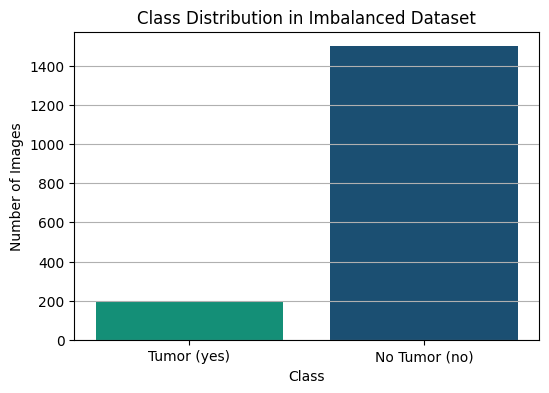

In [8]:
#Count images in each class
tumor_count = len(os.listdir('imbalanced_data/tumor'))
no_tumor_count = len(os.listdir('imbalanced_data/no_tumor'))

# Data for plotting
classes = ['Tumor (yes)', 'No Tumor (no)']
counts = [tumor_count, no_tumor_count]

# Plot
plt.figure(figsize=(6,4))
plt.bar(classes, counts, color=['#148f77', '#1b4f72'])
plt.title('Class Distribution in Imbalanced Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.grid(axis='y')
plt.show()


# **Define the Generator and Discriminator**

In [9]:
import torch
import torch.nn as nn

#Generator
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 2048),
            nn.LayerNorm(2048),
            nn.LeakyReLU(0.2),

            nn.Linear(2048, 4096),
            nn.LayerNorm(4096),
            nn.LeakyReLU(0.2),

            nn.Linear(4096, 8192),
            nn.LayerNorm(8192),
            nn.LeakyReLU(0.2),

            nn.Linear(8192, 64 * 64),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.model(z)
        return out.view(-1, 1, 64, 64)


#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),

            nn.utils.weight_norm(nn.Linear(64 * 64, 4096)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),

            nn.utils.weight_norm(nn.Linear(4096, 2048)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),

            nn.utils.weight_norm(nn.Linear(2048, 1024)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.utils.weight_norm(nn.Linear(1024, 512)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


# **Image transformations standardize all images so the GAN can learn efficiently**

In [10]:
# Image transformations
#standardize all images so the GAN can learn efficiently.
#Normalizing to [-1, 1] is important because the Generator uses a Tanh activation that outputs in that range.
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

tumor_dataset = datasets.ImageFolder(root='imbalanced_data', transform=transform)
tumor_only = [img for img in tumor_dataset if tumor_dataset.classes[img[1]] == 'tumor']
tumor_loader = DataLoader(tumor_only, batch_size=64, shuffle=True)

# **Training the Vanilla GAN**

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
generator = Generator(noise_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)
loss_fn = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001)
epochs = 500

for epoch in range(epochs):
    for imgs, _ in tumor_loader:
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # === Train Generator ===
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        g_loss = loss_fn(discriminator(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # === Train Discriminator ===
        real_loss = loss_fn(discriminator(imgs), real_labels)
        fake_loss = loss_fn(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch+1}/{epochs}] D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[Epoch 1/500] D_loss: 1.2346, G_loss: 0.5987
[Epoch 2/500] D_loss: 0.9880, G_loss: 0.6130
[Epoch 3/500] D_loss: 1.5914, G_loss: 0.7401
[Epoch 4/500] D_loss: 2.6214, G_loss: 0.8435
[Epoch 5/500] D_loss: 1.0128, G_loss: 3.1358
[Epoch 6/500] D_loss: 0.3017, G_loss: 3.2110
[Epoch 7/500] D_loss: 0.4917, G_loss: 1.0178
[Epoch 8/500] D_loss: 0.1654, G_loss: 3.8664
[Epoch 9/500] D_loss: 0.2757, G_loss: 2.4447
[Epoch 10/500] D_loss: 0.4388, G_loss: 1.7969
[Epoch 11/500] D_loss: 0.0324, G_loss: 3.6507
[Epoch 12/500] D_loss: 0.0658, G_loss: 3.0738
[Epoch 13/500] D_loss: 0.0031, G_loss: 6.1635
[Epoch 14/500] D_loss: 0.0799, G_loss: 4.5938
[Epoch 15/500] D_loss: 0.0226, G_loss: 4.1475
[Epoch 16/500] D_loss: 0.0214, G_loss: 4.6831
[Epoch 17/500] D_loss: 0.0047, G_loss: 4.8527
[Epoch 18/500] D_loss: 0.0131, G_loss: 4.7017
[Epoch 19/500] D_loss: 0.0015, G_loss: 6.6466
[Epoch 20/500] D_loss: 0.0068, G_loss: 5.6839
[Epoch 21/500] D_loss: 0.0028, G_loss: 5.6874
[Epoch 22/500] D_loss: 0.0081, G_loss: 6.17

# ***Generate and Save Synthetic Tumor Images***

 Copied 1500 no-tumor images.
 Copied 200 original tumor images.
 Generated 1300 synthetic tumor images.


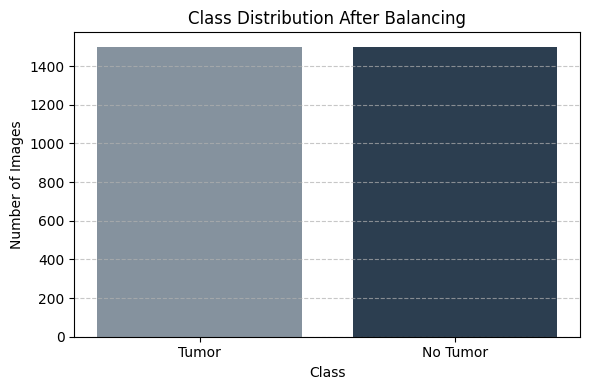

In [12]:

# === Setup Paths ===
tumor_output_dir = "balanced_data_using_vanilla/tumor"
no_tumor_output_dir = "balanced_data_using_vanilla/no_tumor"
os.makedirs(tumor_output_dir, exist_ok=True)
os.makedirs(no_tumor_output_dir, exist_ok=True)

# === Step 1: Copy All No-Tumor Images ===
no_tumor_src = "br35h_dataset/no"
for img in os.listdir(no_tumor_src):
    src = os.path.join(no_tumor_src, img)
    dst = os.path.join(no_tumor_output_dir, img)
    shutil.copyfile(src, dst)
print(f" Copied {len(os.listdir(no_tumor_src))} no-tumor images.")

# === Step 2: Copy 200 Original Tumor Images ===
tumor_src = "br35h_dataset/yes"
original_tumor_images = os.listdir(tumor_src)[:200]  # first 200
for img in original_tumor_images:
    src = os.path.join(tumor_src, img)
    dst = os.path.join(tumor_output_dir, f"tumor_real_{img}")
    shutil.copyfile(src, dst)
print(f" Copied 200 original tumor images.")

# === Step 3: Generate 1300 Synthetic Tumor Images ===
generator.eval()
num_generated = 1300
with torch.no_grad():
    for i in range(num_generated):
        z = torch.randn(1, latent_dim).to(device)
        gen_img = generator(z).cpu()
        gen_img = (gen_img + 1) / 2  # Denormalize to [0,1]
        save_image(gen_img, f"{tumor_output_dir}/tumor_fake_{i}.png")
print(f" Generated {num_generated} synthetic tumor images.")

# === Step 4: Visualize Class Distribution ===
tumor_count = len(os.listdir(tumor_output_dir))
no_tumor_count = len(os.listdir(no_tumor_output_dir))

labels = ["Tumor", "No Tumor"]
counts = [tumor_count, no_tumor_count]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=["#85929e", "#2c3e50"])
plt.title("Class Distribution After Balancing")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


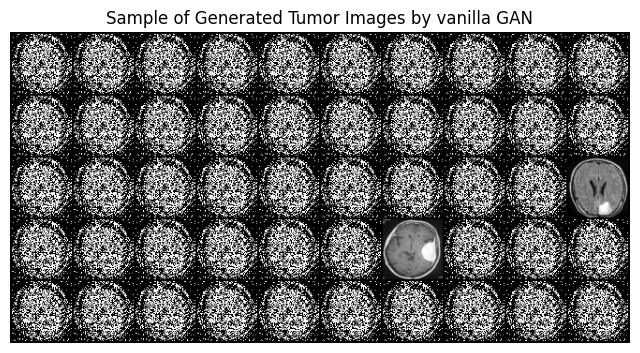

In [22]:
# Path to generated images
generated_dir = "balanced_data_using_vanilla/tumor"
all_imgs = os.listdir(generated_dir)

# Randomly select 16 images
sample_imgs = random.sample(all_imgs, 50)

# Resize transform
resize = Resize((64, 64))

# Load, resize, normalize
images = []
for img_name in sample_imgs:
    img = read_image(os.path.join(generated_dir, img_name)).float() / 255.0
    img = resize(img)
    images.append(img)

# Create grid
grid = make_grid(images, nrow=10)

# Plot
plt.figure(figsize=(8, 8))
plt.title("Sample of Generated Tumor Images by vanilla GAN")
plt.axis("off")
plt.imshow(grid.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
plt.show()


# **Split the dataset into train and validation**

In [14]:
# ==== 1. Setup ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "balanced_data_using_vanilla"
img_size = 64
batch_size = 32
epochs = 10

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [17]:
from torch.utils.data import random_split

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# **Define the CNN classifier**

In [18]:
class TumorCNN(nn.Module):
    def __init__(self):
        super(TumorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 channel (grayscale)
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),  # Binary classification
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)

model = TumorCNN().to(device)


# **Train the CNN**

In [19]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_acc_list, val_acc_list = [], []

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    train_acc = correct / total
    train_acc_list.append(train_acc)

# **Testing and Evaluation**

In [20]:
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 10/10 - Loss: 2.7582, Train Acc: 0.9900, Val Acc: 0.9617


Evaluation Metrics:
Accuracy:  0.9617
Precision: 0.9894
Recall:    0.9331
F1-Score:  0.9604
AUC-ROC:   0.9941


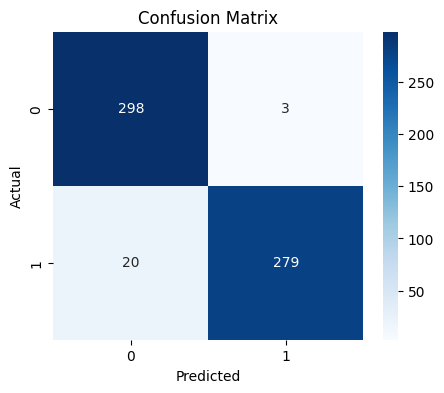

In [21]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
import seaborn as sns

# ==== Collect predictions ====
model.eval()
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        probs = outputs.cpu().numpy()
        preds = (outputs > 0.5).float().cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Flatten
all_labels = [int(l[0]) for l in all_labels]
all_preds = [int(p[0]) for p in all_preds]
all_probs = [float(p[0]) for p in all_probs]

# ==== Metrics ====
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)

print("Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

# ==== Confusion Matrix ====
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
